# Detecting Clickbaits

In [ ]:
!pip install estnltk==1.7.1
!pip install lazypredict

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.feature_extraction.text import CountVectorizer
from estnltk import Text
import re
import string

import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import ttest_ind
from scipy.stats import kstest
import scipy.stats as st
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

In [3]:
df = pd.read_csv('data.csv') 
df

,sentence,article_url,has_adjective,no_adjectives,has_verb,no_verbs,has_name,no_names,no_words_starting_with_capslock,no_words_with_only_capslock,has_exclamation_mark,has_question_mark,has_numbers,starts_with_number,no_words,no_characters,contains_gtp_reccomended_word,label
0,"""Taolist valu, kui oma lapse pärast, pole mina veel varem kogenud."" Katrin Lust pidi vahetult enne jõule kutsuma koju kiirabi",https://kroonika.delfi.ee/artikkel/120119046/taolist-valu-kui-oma-lapse-parast-pole-mina-veel-varem-kogenud-katrin-lust-pidi-vahetult-enne-joule-kutsuma-koju-kiirabi?fbclid=IwAR1CNp6XyzGl3DpPnNguTWj4oil9GmjrFDvz_fAjgK5xrWiyYVNxC16yRdk,1,3,1,2,1,2,2,0,0,0,0,0,20,101,0,1
1,"Isegi BBC-s | Selgus, kes oli see hulljulge eestlane, kes Tallinna vanalinnast suuskadel alla laskus",https://sky.ee/selgus-kes-oli-see-hulljulge-eestlane-kes-tallinna-vanalinnast-suuskadel-alla-laskus?fbclid=IwAR3GO7Nae3VcaEhPDoxQudKg7s8MQiuIVXvP58JekswZa-bhaS034aC3VWE,1,2,1,2,1,4,4,0,0,0,0,0,15,82,0,1
2,Palju õnne! Jaagup Kreem ja tema abikaasa Kristiina tähistasid olulist tähtpäeva,https://kroonika.delfi.ee/artikkel/120117474/palju-onne-jaagup-kreem-ja-tema-abikaasa-kristiina-tahistasid-olulist-tahtpaeva?fbclid=IwAR2aQ1zuFm7XbNJiIDpWN3ZpcEJapoeNNaTOetp7JQg8Wd-lRhR2i0NC6FY,1,1,1,2,1,5,4,0,1,0,0,0,11,69,0,1
3,Justin Bieber on ühe eriti suure ja tulusa tehingu lävel,https://sky.ee/justin-bieber-uhe-eriti-suure-ja-tulusa-tehingu-lavel?fbclid=IwAR3ltZbN5zfXDdgMwPUfThai0Iq9lZ2AwJ3eadcdY8iOkJtf5o14zlNzGJ8,1,3,0,0,1,3,2,0,0,0,0,0,10,47,0,1
4,Lahkus armastatud inglise laulja,https://kultuur.postimees.ee/7674683/lahkus-armastatud-inglise-laulja?fbclid=IwAR0PAOkNCsQnIeaL95wc_BnUfWzcTQSOZ1J9W7iUaaeuijyPDksVO2or3NE,1,2,1,2,0,0,1,0,0,0,0,0,4,29,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,VIDEOD | Maailmameister Argentina jõudis kodumaale,https://sport.err.ee/1608826138,1,1,1,1,1,1,3,1,0,0,0,0,6,44,0,0
1648,Koeru õpilased kasvatavad kooli nutikasvuhoones salatit,https://www.err.ee/1608826480,0,0,1,1,1,1,1,0,0,0,0,0,6,50,0,0
1649,Jäised olud jätkuvad ka kolmapäeval,https://www.err.ee/1608826489,1,2,1,1,0,0,1,0,0,0,0,0,5,31,0,0
1650,"""UV faktoris"" võtsid aasta kokku peatoimetajad ja üllatuskülalised",https://www.err.ee/1608826492,0,0,1,1,0,0,0,1,0,0,0,0,8,57,0,0


In [4]:
df.starts_with_number.unique()

array([0])

## Data Exploration

### Class frequency

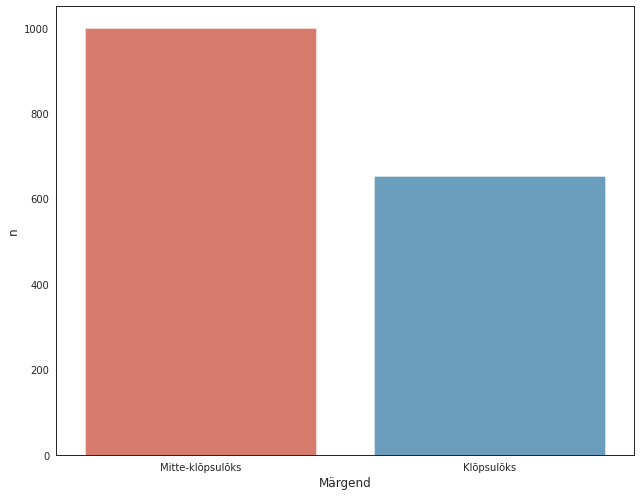

In [5]:
style.use('ggplot')
sns.set_style('white')

plt.figure(figsize=(9,7))
fig=sns.countplot(df['label'], alpha =.80) 
#plt.title('Klõpsulõks vs mitte-klõpsulõks')
plt.ylabel('n')
plt.xlabel('Märgend')
fig.set(xticklabels=['Mitte-klõpsulõks','Klõpsulõks'])
plt.tight_layout()
#plt.savefig('class_dist')
plt.show()

### Number of words per headline type

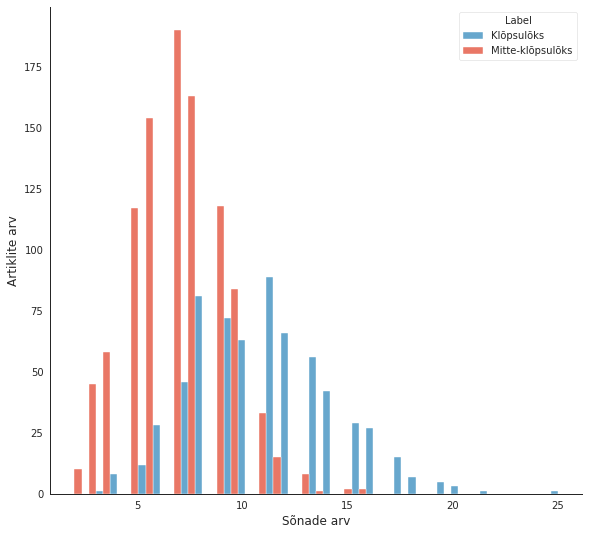

In [6]:

ax = sns.displot(df, x="no_words", hue="label", multiple="dodge", legend = False)
ax.fig.set_size_inches(9,8)
ax.set(xlabel='Sõnade arv', ylabel='Artiklite arv')
plt.legend(title='Label', labels=['Klõpsulõks', 'Mitte-klõpsulõks']) 
#plt.savefig('words_dist')
plt.show()

In [7]:
pd.options.display.max_colwidth = 170
df[['sentence', 'label']][df["no_words"] > 19] 

,sentence,label
0,"""Taolist valu, kui oma lapse pärast, pole mina veel varem kogenud."" Katrin Lust pidi vahetult enne jõule kutsuma koju kiirabi",1
14,VIDEO | Hendrik Terrase jube õhtu Pärnus: kas ta oli suhtes Brigittega juba enne võtteid? Kas ta on maganud 250 naisega? Kuidas see poliitkarjäärile mõjub?,1
400,"Kas Kadri Simson põdes koroonaviiruse talvel läbi? Simson: mul oli kuiv köha, palavik ja nohu. Nii haige pole täiskasvanuna olnudki",1
412,"Kelle kaissu läks võiduööl Eesti ihaldatuim poissmees? Uku Suviste: saan tunda täpselt neid tunded, mis on minu sees ja siirad",1
495,"Tanel Padarit köidab laulmise kõrvalt ka üks väga põnev valdkond: kui ma ei oleks laulja, oleksin nähtavasti ammu juba sellele pühendunud",1


In [8]:
df[['sentence', 'label']][df["no_words"] < 5] 

,sentence,label
4,Lahkus armastatud inglise laulja,1
7,Kas tõesti tulnukad?,1
21,Üllatav tegur tõstab vähiriski,1
36,Tapal läks toit kõrbema,1
179,Teatrivaataja lemmik on ...,1
...,...,...
1620,ERR-i teleuudised kell 9:00,0
1622,Aeg-ajalt sajab vihma,0
1625,Raadiouudised (21.12.2022 09:00:00),0
1630,ERR-i teleuudised kell 7:00,0


In [9]:
words_clickbait = df.loc[df.label==1, 'no_words'].values
words_not_clickbait = df.loc[df.label==0, 'no_words'].values

# create 95% confidence interval
print(st.norm.interval(alpha=0.95,
              loc=np.mean(words_clickbait),
              scale=st.sem(words_clickbait)))
print(np.mean(words_clickbait))

(10.557861531738231, 11.058702885439684)
10.808282208588958


In [10]:
print(st.norm.interval(alpha=0.95,
              loc=np.mean(words_not_clickbait),
              scale=st.sem(words_not_clickbait)))
print(np.mean(words_not_clickbait))

(7.016188174722524, 7.293811825277476)
7.155


In [11]:
stat, p_value = ttest_ind(words_clickbait, words_not_clickbait)
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-test: statistic=26.9800, p-value=0.0000


In [12]:
stat, p_value = kstest(words_clickbait, words_not_clickbait)
print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Kolmogorov-Smirnov Test: statistic=0.4746, p-value=0.0000


### Headline contains a '?'


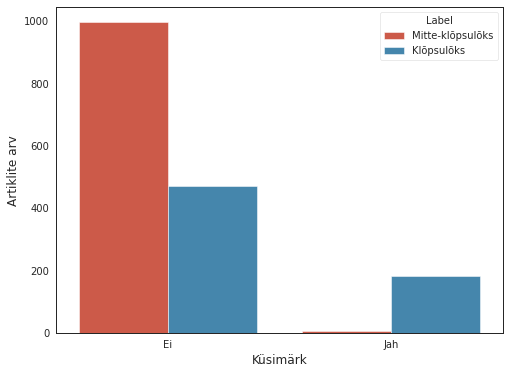

In [13]:
plt.figure(figsize = (8,6))
ax = sns.countplot(x ='has_question_mark', hue = "label", data = df)
ax.set(xlabel="Küsimärk", ylabel='Artiklite arv')
plt.legend(title='Label', labels=['Mitte-klõpsulõks', 'Klõpsulõks'])
ax.set(xticklabels=['Ei','Jah'])
#plt.savefig('kysi_dist')
plt.show()

In [14]:
df[['sentence', 'label']][(df["has_question_mark"] == 1) & (df['label'] == 0)] 

,sentence,label
891,"R2 Aastahitt | 5miinust ""?mis sa tegid""",0
1078,"Arvustus. Kadri-Ann Sumera ""Basiliski lapsed"": kust küll kõik need lollid tulid?",0
1297,Viktoriin: millised olid ajaloolised jõulukombed?,0
1508,Minutiloeng: kust tuleb tänapäeva kingiiha?,0
1633,Viktoriin: mida kujutab endast jõuludele eelnev toomapäev?,0


### Headline contains a '!'

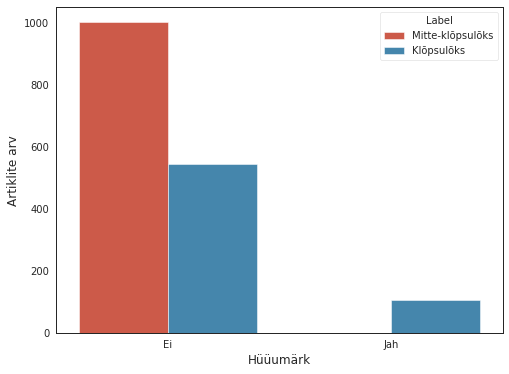

In [15]:
plt.figure(figsize = (8,6))
ax = sns.countplot(x ='has_exclamation_mark', hue = "label", data = df)
ax.set(xlabel="Hüüumärk", ylabel='Artiklite arv')
plt.legend(title='Label', labels=['Mitte-klõpsulõks', 'Klõpsulõks'])
ax.set(xticklabels=['Ei','Jah'])
#plt.savefig('hyyu_dist')
plt.show()

In [16]:
df[['sentence', 'label']][(df["has_exclamation_mark"] == 1) & (df['label'] == 0)] 

,sentence,label


### Top x clickbait headline words




In [17]:
# preprocess
with open('estonian-stopwords.txt', encoding='utf-8') as f:
    stop_words_est = [word for line in f for word in line.split()]

def text_preprocess_est(x):
    x = x.lower() # lower casing
    x = ' '.join([word for word in x.split(' ') if word not in stop_words_est]) # remove stop words
    # x = x.encode('ascii', 'ignore').decode() # remove unicode characters # commented out cuz removes also ö,ä,ü,õ
    x = re.sub(r'https*\S+', ' ', x) # remove urls
    x = re.sub(r'\'\w+', '', x) # remove ticks and the next character
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x) # remove punctuations
    x = re.sub(r'\s{2,}', ' ', x) # replace the over spaces
    return x

df['clean_text'] = df['sentence'].apply(text_preprocess_est)

In [18]:
# initialize CounVectorizer
def create_term_matrix(in_data):
    cv = CountVectorizer(analyzer = 'word')
    data = cv.fit_transform(in_data['clean_text'])
    tm_matrix = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
    tm_matrix.index = in_data.index
    return tm_matrix.sum().transpose()

In [19]:
# subset data
clickbait_df = df[df["label"] == 1] 
non_clickbait_df = df[df["label"] == 0] 
print(len(clickbait_df))
print(len(non_clickbait_df))

652
1000


In [20]:
# print top15 clickbait words
clickbait_words = create_term_matrix(clickbait_df)
clickbait_words = pd.DataFrame(clickbait_words.items(), columns=['word', 'n'])
clickbait_words_plot = clickbait_words.sort_values(by='n', ascending=False).head(30)
print(clickbait_words.sort_values(by='n', ascending=False).head(15))

            word   n
313        eesti  44
3162       video  30
1928   paljastas  22
2192     põhjuse  19
1542        mees  18
475         foto  18
183      avaldas  17
2749  tegelikult  16
2442      selgus  16
1695       naine  14
2720       teada  14
3048       vaata  13
40         aitab  13
476        fotod  13
3387    üllatava  13


Text(0, 0.5, 'n')

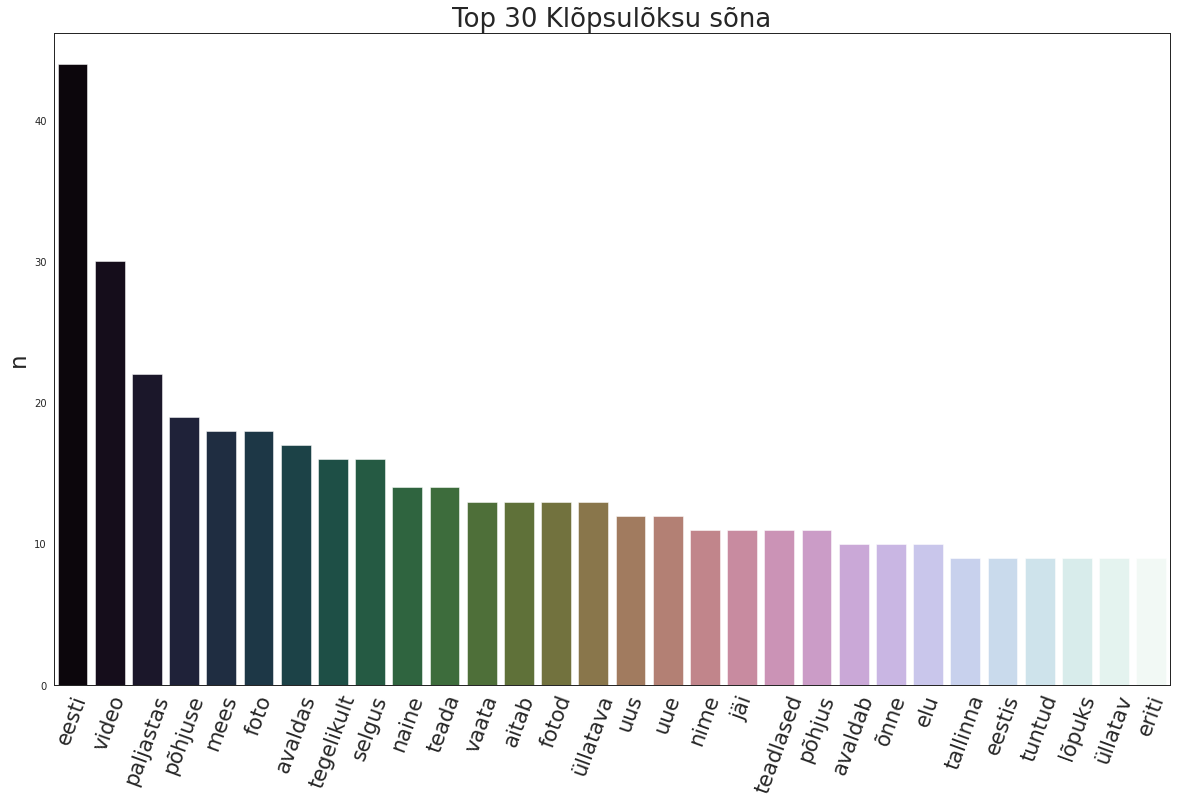

In [21]:
plt.figure(figsize=(20, 12))
sns.barplot(data = clickbait_words_plot, x = 'word', y = 'n', palette='cubehelix')
plt.xticks(fontsize=21)
plt.xticks(rotation=70)
plt.title('Top 30 Klõpsulõksu sõna', fontsize=26)
plt.xlabel('')
plt.ylabel('n', fontsize=23)
#plt.savefig('clickbait_words')

### Top x non-clickbait headline words

In [22]:
# print top15 non-clickbait words
non_clickbait_words = create_term_matrix(non_clickbait_df)
non_clickbait_words = pd.DataFrame(non_clickbait_words.items(), columns=['word', 'n'])
non_clickbait_words_plot = non_clickbait_words.sort_values(by='n', ascending=False).head(30)
print(non_clickbait_words.sort_values(by='n', ascending=False).head(15))

               word   n
3             aasta  48
390           eesti  47
1123           kell  32
93        aktuaalne  25
981         kaamera  25
3452        ukraina  22
585         galerii  21
2590  raadiouudised  21
3631        venemaa  19
3481            uue  19
3134          tartu  18
3649          video  17
11           aastal  17
3626           vene  16
3071           taas  15


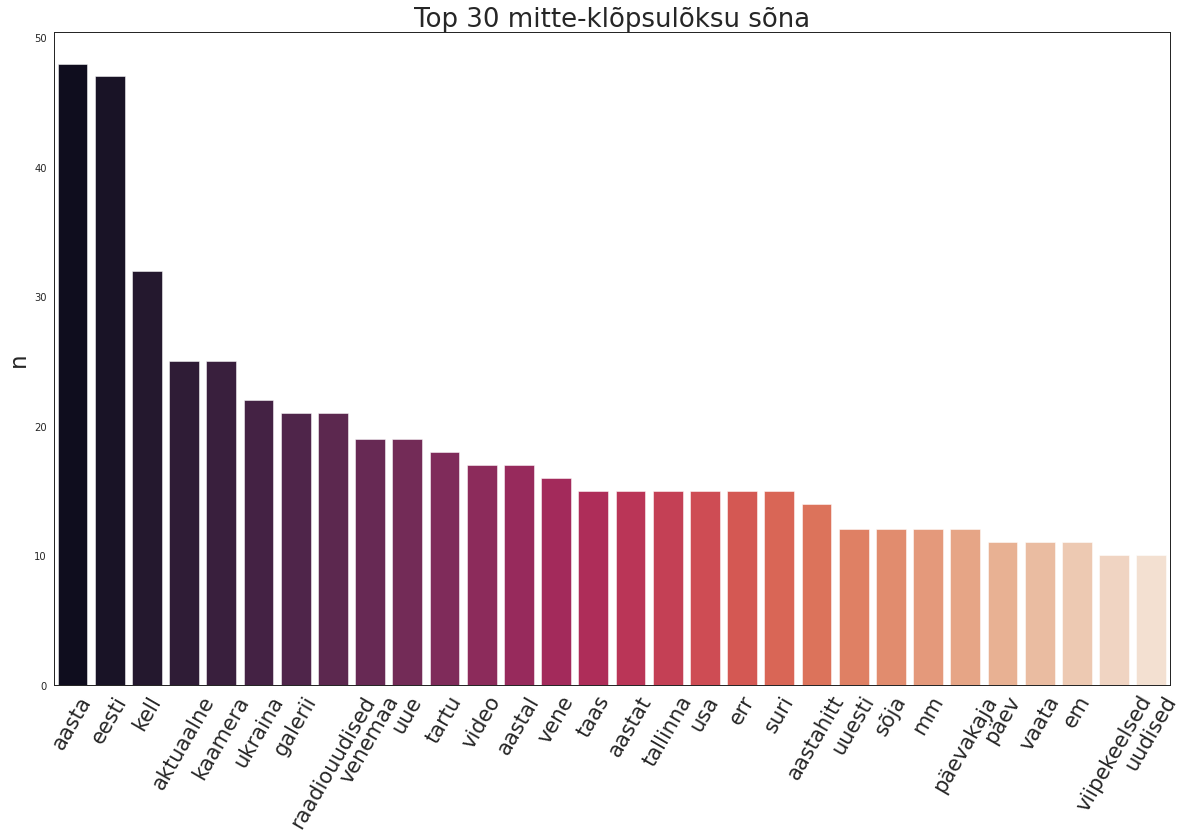

In [23]:
plt.figure(figsize=(20, 12))
sns.barplot(data = non_clickbait_words_plot, x = 'word', y = 'n', palette='rocket')
plt.xticks(fontsize=21)
plt.xticks(rotation=60)
plt.title('Top 30 mitte-klõpsulõksu sõna', fontsize=26)
plt.xlabel('')
plt.ylabel('n', fontsize=23)
plt.savefig('non_clickbait_words')

## Modeling

- Lazy Predict library: https://lazypredict.readthedocs.io/en/latest/usage.html#classification 

In [24]:
X = df.drop(['label', 'clean_text', 'sentence', 'article_url', 'starts_with_number'], axis = 1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 2023)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:04<00:00,  6.22it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.86,0.84,0.84,0.86,0.16
LinearSVC,0.86,0.84,0.84,0.85,0.10
KNeighborsClassifier,0.86,0.84,0.84,0.85,0.12
CalibratedClassifierCV,0.86,0.84,0.84,0.85,0.50
NuSVC,0.86,0.84,0.84,0.86,0.20
LogisticRegression,0.85,0.84,0.84,0.85,0.09
AdaBoostClassifier,0.85,0.84,0.84,0.85,0.31
LGBMClassifier,0.84,0.84,0.84,0.84,0.16
RidgeClassifierCV,0.86,0.83,0.83,0.85,0.04


### Logistic Regression

In [25]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test) 

print('intercept ', log_reg.intercept_[0])
print('classes', log_reg.classes_)
print('----------------------')
print("F1 score of the model")
print(f1_score(y_test,y_pred))
print('----------------------')
print("Accuracy of the model")
print(accuracy_score(y_test,y_pred))
print('----------------------')
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))
print('----------------------')
print("Classification Report")
print(classification_report(y_test,y_pred))
print('----------------------')
print("auc/roc")
auc = metrics.roc_auc_score(y_test, y_pred)
auc

intercept  -4.46169285990515
classes [0 1]
----------------------
F1 score of the model
0.8215962441314555
----------------------
Accuracy of the model
0.8608058608058609
----------------------
Confusion Matrix
[[295  23]
 [ 53 175]]
----------------------
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       318
           1       0.88      0.77      0.82       228

    accuracy                           0.86       546
   macro avg       0.87      0.85      0.85       546
weighted avg       0.86      0.86      0.86       546

----------------------
auc/roc


0.8476084078119829

In [33]:
# find p-values for coefs
freg=f_regression(X_train, y_train)
p=freg[1]
print(p.round(3))

[0.    0.    0.    0.    0.001 0.017 0.    0.    0.    0.    0.    0.
 0.    0.004]


In [43]:
pd.set_option('display.float_format', '{:.4f}'.format)

coef_df = pd.DataFrame({'coeff': log_reg.coef_[0],'exp(coeff)': np.exp(log_reg.coef_[0])}, index=X.columns) # ,'clickbait_prob_compared_to_group0':(1/np.exp(log_reg.coef_[0]))
coef_df['p'] = freg[1]
coef_df.reindex(coef_df.coeff.sort_values(ascending = False).index)

,coeff,exp(coeff),p
has_question_mark,3.6750,39.4475,0.0000
has_exclamation_mark,2.6762,14.5304,0.0000
no_words_with_only_capslock,0.8488,2.3369,0.0000
no_verbs,0.6439,1.9038,0.0000
no_words,0.5251,1.6906,0.0000
has_adjective,0.2717,1.3122,0.0000
no_adjectives,0.2490,1.2827,0.0000
no_words_starting_with_capslock,0.1591,1.1724,0.0000
contains_gtp_reccomended_word,0.0490,1.0503,0.0041
no_characters,-0.0293,0.9711,0.0000


Because of the logit function, logistic regression coefficients represent the log odds that an observation is in the target class (“1”) given the values of its variables. Thus, these log odd coefficients need to be converted to regular odds in order to make sense of them --> `np.exp() `

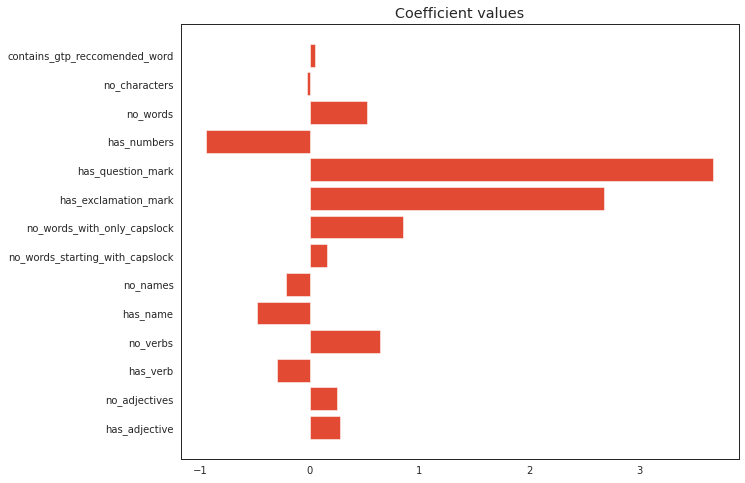

In [28]:
plt.figure(figsize=(10,8))
plt.barh(X.columns,log_reg.coef_[0])
plt.title("Coefficient values")
plt.show()

### Misclassified samples

In [60]:
indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
X_test_val = X_test[:]
X_test_val['actual'] = y_test
X_test_val['pred'] = y_pred
wrong_predictions = X_test_val.iloc[indices,:]

In [112]:
sentences = []

for idx, row in wrong_predictions.iterrows():
  idx = row.name
  sentence = df[df.index == idx].sentence.item()
  sentences.append(sentence)

wrong_predictions['sentences'] = sentences

In [117]:
fn = wrong_predictions[(wrong_predictions["actual"] == 1) & (wrong_predictions["pred"] == 0)]
fp = wrong_predictions[(wrong_predictions["actual"] == 0) & (wrong_predictions["pred"] == 1)]

print(len(fn))
print(len(fp))

53
23


In [123]:
fn['sentences']

590                          Sisekujundaja ülestunnistus: see sisustusdetail ei ole oma kõrget hinda väärt
458                                Uudo Sepp paljastas üllatava põhjuse, miks jäi katki muusiku haridustee
117                                                   Tassitäis seda armastatud jooki aitab põletada rasva
32                                                                         Selgus Riho Sibula surma põhjus
450                                  Toidupoes lotovõidu puhul kõikide eest maksnud naine osutus hoopis...
189                              Tiitlikaitsja Prantsusmaa peab MM-il hakkama saama ilma oma tähtmängijata
19                     Riho Sibula tütar Iris paljastas, miks avalikkus tema olemasolust siiani ei teadnud
618                                                             See lihtne sõna on õnneliku abielu saladus
506                                               Video: naine tõmbas järvest välja kala, kellel oli .....
574                                  

In [125]:
fp['sentences']

1412                               Sõja 302. päev: Venemaale võib olla küüditatud sadu tuhandeid Ukraina lapsi
752                                                     Vaata uuesti: "Ühe maja lugu" viib vaatajad Estoniasse
1067                             Karilatsi muuseumi perepäevadel saab sõita saaniga ja mängida vanu jõulumänge
747                             Janek Õiglane: ma ei osanud pärast EM-i mõelda, et võiksin isegi nominent olla
891                                                                    R2 Aastahitt | 5miinust "?mis sa tegid"
1154                                                              Karge jõuluilm asendub niiske ja sooja õhuga
1221                           Anne Veski: kõige õudsem ongi see, et sa lähed koju ja seal ei ole mitte kedagi
1257                                 Jefimova soovid uueks aastaks: saada terveks ja näidata paremaid tulemusi
1186           Meditsiiniõde: diabeedi pärimise protsent on väike, aga raseduse ajal võivad tüsistused tekkida
1